In [1]:
import pandas as pd
import glob
import os

In [103]:
def standardize_column_names(df):
    """
    Standardize column names by:
    1. Converting to lowercase
    2. Replacing spaces with underscores
    3. Removing special characters
    4. Handling common variations in column names
    """
    # Create a mapping dictionary for common variations
    column_mapping = {
        'month(number)': 'month_number',
        'fiscal month': 'fiscal_month',
        'fiscal year': 'fiscal_year',
        'vendor name': 'vendor_name',
        'account descr': 'account_descr',
        'dept name': 'dept_name',
        '6 digit org name': 'c6_digit_org_name',
        'monetary amount': 'monetary_amount',
        'voucher line': 'voucher_line',
        'distribution line': 'distribution_line'
    }
    
    # Step 1: Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Step 2: Replace spaces with underscores
    df.columns = df.columns.str.replace(' ', '_')
    
    # Step 3: Apply specific mappings
    renamed_columns = {}
    for col in df.columns:
        space_version = col.replace('_', ' ')
        if space_version in column_mapping:
            renamed_columns[col] = column_mapping[space_version]
            
    # Apply the rename
    df = df.rename(columns=renamed_columns)
    
    return df

def process_data_types(df):
    """
    Process data types for specific columns:
    - Convert 'entered' to datetime
    - Ensure 'dept_name' is string
    - Ensure 'monetary_amount' is float
    """
    # Convert 'entered' to datetime
    df['entered'] = pd.to_datetime(df['entered'], format='%m/%d/%Y')
    
    # Ensure dept_name is string type
    df['dept_name'] = df['dept_name'].fillna('Unknown').astype(str)
    
    # Ensure monetary_amount is float
    # First remove any currency symbols and commas, then convert to float
    df['monetary_amount'] = df['monetary_amount'].astype(str).str.replace('$', '', regex=False)
    df['monetary_amount'] = df['monetary_amount'].str.replace(',', '', regex=False)
    df['monetary_amount'] = pd.to_numeric(df['monetary_amount'])
    
    return df

def save_dataframe(df, output_path):
    """
    Save DataFrame with dates in MM/DD/YYYY format
    """
    df_to_save = df.copy()
    if 'entered' in df_to_save.columns and pd.api.types.is_datetime64_any_dtype(df_to_save['entered']):
        df_to_save['entered'] = df_to_save['entered'].dt.strftime('%m/%d/%Y')
    df_to_save.to_csv(output_path, index=False, encoding='utf-8-sig')

def process_checkbook_files(data_directory):
    """
    Process and combine checkbook CSV files while handling column name inconsistencies
    and data types.
    """
    # Define file pattern
    file_pattern = os.path.join(data_directory, 'checkbook-explorer-fy*.csv')
    csv_files = glob.glob(file_pattern)
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found matching pattern: {file_pattern}")
    
    df_list = []
    
    # Define dtypes for reading CSV
    dtype_dict = {
        'dept_name': str,
        'monetary_amount': float
    }
    
    # Read and standardize each CSV file
    for file in csv_files:
        try:
            # Read the CSV file with specified dtypes but without parse_dates
            temp_df = pd.read_csv(
                file,
                encoding='iso-8859-1',
                low_memory=False,
                dtype=dtype_dict
            )
            
            # Standardize column names immediately upon loading
            temp_df = standardize_column_names(temp_df)
            
            # Process data types after standardizing column names
            temp_df = process_data_types(temp_df)
            
            df_list.append(temp_df)
            print(f"Successfully loaded and standardized {file} with {temp_df.shape[0]} records.")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)
    print("\nConcatenation successful.")
    
    # Final data type processing on combined DataFrame
    combined_df = process_data_types(combined_df)
    
    # Save the combined DataFrame using the new save function
    output_path = os.path.join(data_directory, 'combined_checkbook_2012_2024_cleaned.csv')
    save_dataframe(combined_df, output_path)
    print(f"\nSaved combined and cleaned data to: {output_path}")
    
    return combined_df

if __name__ == "__main__":
    # Replace with your actual directory path
    DATA_DIR = 'data/'
    
    # Process the files
    combined_df = process_checkbook_files(DATA_DIR)
    
    # Display information about the final DataFrame
    print("\nFinal DataFrame Info:")
    print(combined_df.info())
    print("\nSample of combined data:")
    print(combined_df.head())
    
    # Check for any remaining NaN values
    print("\nNaN value counts:")
    print(combined_df.isna().sum())

Successfully loaded and standardized data/checkbook-explorer-fy12.csv with 168180 records.
Successfully loaded and standardized data/checkbook-explorer-fy15.csv with 129713 records.
Successfully loaded and standardized data/checkbook-explorer-fy13.csv with 134478 records.
Successfully loaded and standardized data/checkbook-explorer-fy19.csv with 139037 records.
Successfully loaded and standardized data/checkbook-explorer-fy14.csv with 147111 records.
Successfully loaded and standardized data/checkbook-explorer-fy17.csv with 149969 records.
Successfully loaded and standardized data/checkbook-explorer-fy20.csv with 112315 records.
Successfully loaded and standardized data/checkbook-explorer-fy22.csv with 113491 records.
Successfully loaded and standardized data/checkbook-explorer-fy21.csv with 89090 records.
Successfully loaded and standardized data/checkbook-explorer-fy23.csv with 118859 records.
Successfully loaded and standardized data/checkbook-explorer-fy24.csv with 111904 records.


# Read CSV

In [90]:
combined_df = pd.read_csv('data/combined_checkbook_2012_2024_cleaned.csv', low_memory=False, parse_dates=['entered'])
combined_df.head()

,ï»¿_id,voucher,voucher_line,distribution_line,entered,month_number,fiscal_month,month,fiscal_year,year,vendor_name,account,account_descr,dept,dept_name,c6_digit_org_name,monetary_amount
0,1,10112669,1,1,2012-02-21,2,8,Febraury,2012,2012,Office Max,53909,MiscSup Other,101068,Boston Public School Dept,Chief Operating Officer,488
1,2,10112692,1,1,2012-03-02,3,9,March,2012,2012,Positive Promotions,52907,Cont Serv Other,101097,Boston Public School Dept,Food & Nutrition Svc,1450
2,3,11312001,1,1,2011-11-17,11,5,November,2012,2011,"P.J. Systems,Inc. DBA",53905,MiscSup Major Computer Syst,113100,Office of New Bostonians,New Bostonians,908
3,4,13112001,1,1,2011-07-29,7,1,July,2012,2011,"Shepard,Barbara",52907,Cont Serv Other,101630,Boston Public School Dept,Charlestown High School,1818
4,5,13112002,1,1,2011-07-29,7,1,July,2012,2011,The Commonwealth of Massachusetts,54901,Current Dues/Membership,19096B,Boston Community Centers,Community Child Care Voucher,75


In [91]:
combined_df.drop(columns=['ï»¿_id', 'voucher', 'voucher_line', 'distribution_line', 
                          'month_number', 'fiscal_month', 'month', 'fiscal_year', 
                          'year', 'vendor_name', 'account', 'account_descr',
                         'c6_digit_org_name'], inplace=True)
combined_df.shape

(1702307, 4)

In [92]:
combined_df.head()

,entered,dept,dept_name,monetary_amount
0,2012-02-21,101068,Boston Public School Dept,488
1,2012-03-02,101097,Boston Public School Dept,1450
2,2011-11-17,113100,Office of New Bostonians,908
3,2011-07-29,101630,Boston Public School Dept,1818
4,2011-07-29,19096B,Boston Community Centers,75


# Mapping Departments to Cabinet

In [74]:
cabinet_mapping = {
    # Finance Cabinet

    'Purchasing Division': 'Finance Cabinet',
    'Collecting Division': 'Finance Cabinet',
    'Auditing Department': 'Finance Cabinet',
    'Off Of Administration & Financ': 'Finance Cabinet',
    'Assessing Department': 'Finance Cabinet',
    'Office of Finance & Budget': 'Finance Cabinet',
    'Budget Management': 'Finance Cabinet',
    'Treas Dept - Treasury Division': 'Finance Cabinet',
    'Execution of Courts': 'Finance Cabinet',
    'Administration & Finance': 'Finance Cabinet',
    'Procurement': 'Finance Cabinet',
    'Office of Finance': 'Finance Cabinet',
    'Office of Participatory Budget': 'Finance Cabinet',
    'Lease Contracts Clearing Accou': 'Finance Cabinet',
    'Major Vendor Clearing Account': 'Finance Cabinet',
    'Risk Retention Reserve': 'Finance Cabinet',
    
    # Education Cabinet
    'Boston Public School Dept': 'Education Cabinet',

    # Streets Cabinet
    'Central Fleet Management': 'Streets Cabinet',
    'Off. of Chief of PWD - Transp': 'Streets Cabinet',
    'Snow Removal': 'Streets Cabinet',
    'Public Works Department': 'Streets Cabinet',
    'Transportation Department': 'Streets Cabinet',
    'Parking Clerk': 'Streets Cabinet',
    'Traffic Department': 'Streets Cabinet',
    'Ofc. of Strts., Trnsp. & Sanit': 'Streets Cabinet',
    'Snow & Winter management': 'Streets Cabinet',
    'Office of Streets': 'Streets Cabinet',
    'Snow & Winter Management': 'Streets Cabinet',

    # Mayor's Cabinet
    "Mayor's Office": "Mayor's Cabinet",
    "Mayor's Office of Housing": "Mayor's Cabinet",
    'Office of New Bostonians': "Mayor's Cabinet",
    'Law Department': "Mayor's Cabinet",
    'Department of Voter Mobilizati': "Mayor's Cabinet",
    'Intergovernmental Relations': "Mayor's Cabinet",
    'Election Department': "Mayor's Cabinet",
    'Listing Board': "Mayor's Cabinet",
     'Boston Housing Authority': "Mayor’s Cabinet",
     'Housing Trust Fund': "Mayor’s Cabinet",
     'Leading the Way': "Mayor’s Cabinet",

    # People Operations Cabinet
    'Labor Relations': 'People Operations Cabinet',
    'Human Resources': 'People Operations Cabinet',
    'Workers Compensation Fund': 'People Operations Cabinet',
    'Health Insurance': 'People Operations Cabinet',
    'Registry Division': 'People Operations Cabinet',
    'Office of People Operations': 'People Operations Cabinet',

    # Public Safety Cabinet
    'Fire Department': 'Public Safety Cabinet',
    'Police Department': 'Public Safety Cabinet',
    'Emergency Management': 'Public Safety Cabinet',
    'Emergency Shelter Commission': 'Public Safety Cabinet',
    'Emergency Preparedness': 'Public Safety Cabinet',

    # Public Health Cabinet
    'Dept of Health and Hospitals': 'Public Health Cabinet',

    # Information & Technology Cabinet
    'Dpt of Innovation & Technology': 'Information & Technology Cabinet',
    'SPO Intelepath Centrex': 'Information & Technology Cabinet',
    
    # Planning Cabinet
    'Neighborhood Development': 'Planning Cabinet',
    'Planning': 'Planning Cabinet',
    'Boston Redevelopment Authority': 'Planning Cabinet',

    # Operations Cabinet
    'Inspectional Services Dept': 'Operations Cabinet',
    'Property & Construction Mgmnt': 'Operations Cabinet',
    'Property Management': 'Operations Cabinet',
    'Public Facilities Dept': 'Operations Cabinet',

    # Arts & Culture Cabinet
    'Office of Arts & Culture': 'Arts & Culture Cabinet',
    'Library Department': 'Arts & Culture Cabinet',

    # Economic Opportunity & Inclusion Cabinet
    'Licensing Board': 'Economic Opportunity & Inclusion Cabinet',
    'Arts, Tourism & Special Events': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Economic Development': 'Economic Opportunity & Inclusion Cabinet',
    'Boston Residents Jobs Policy': 'Economic Opportunity & Inclusion Cabinet',
    'Small and  Local Business': 'Economic Opportunity & Inclusion Cabinet',
    'Consumer Affairs & Licensing': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Tourism': 'Economic Opportunity & Inclusion Cabinet',
    'Special Events And Tourism': 'Economic Opportunity & Inclusion Cabinet',
    'Office of Eco Opp & Inclusion': 'Economic Opportunity & Inclusion Cabinet',
    'Supplier and Workforce Diversi': 'Economic Opportunity & Inclusion Cabinet',
    'Supplier Diversity': 'Economic Opportunity & Inclusion Cabinet',

    # Worker Empowerment Cabinet
    'Youth Engagement & Employment': 'Worker Empowerment Cabinet',
    'Youth Employment & Opportunity': 'Worker Empowerment Cabinet',
    'Labor Compliance & Worker Prot': 'Worker Empowerment Cabinet',

    # Equity & Inclusion Cabinet
    "Women's Commission": 'Equity & Inclusion Cabinet',
    'Civil Rights': 'Equity and Inclusion',
    'Com. for Persons With Disabili': 'Equity & Inclusion Cabinet',
    'Fair Housing & Equity': 'Equity & Inclusion Cabinet',
    "Women's Advancement": 'Equity & Inclusion Cabinet',
    'Ofc of Immigrant  Advancement': 'Equity & Inclusion Cabinet',
    'Immigrarant Advancement': 'Equity & Inclusion Cabinet',
    'Office of Equity': 'Equity & Inclusion Cabinet',
    'Lang. & Communication Access': 'Equity & Inclusion Cabinet',
    'Resiliency & Racial Equity': 'Equity & Inclusion Cabinet',
    'LGBTQ+ Advancement': 'Equity & Inclusion Cabinet',
    'Human Right Commission': 'Equity & Inclusion Cabinet',
    'Office of Diversity': 'Equity & Inclusion Cabinet',
    'Black Male Advancement': 'Equity & Inclusion Cabinet',

    # Environment, Energy & Open Space Cabinet
    'Parks & Recreation Department': 'Environment, Energy & Open Space Cabinet',
    'Cemetery Division': 'Environment, Energy & Open Space Cabinet',
    'Environment Department': 'Environment, Energy & Open Space Cabinet',
    'Office of Food Justice': 'Environment, Energy & Open Space Cabinet',
    'Office of Historic Preservatio': 'Environment, Energy & Open Space Cabinet',
    'Office of HistoricPreservation': 'Environment, Energy & Open Space Cabinet',

    # Human Services Cabinet
    'Age Strong': 'Human Services Cabinet',
    'Office of Health & Human Servi': 'Human Services Cabinet',
    'Age Strong Commission': 'Human Services Cabinet',
    'Office of Human Services': 'Human Services Cabinet',
    'Elderly Commission': 'Human Services Cabinet',
    "Veterans' Services": 'Human Services Cabinet',
    'Boston Center-Youth & Families': 'Human Services Cabinet',
    'Youth Fund': 'Human Services Cabinet',

    # Community Engagement Cabinet
    'Neighborhood Services': 'Community Engagement Cabinet',
    'Boston Community Centers': 'Community Engagement Cabinet',

    # Non-Mayoral Departments
    'City Clerk': 'Non-Mayoral Departments',
    'City Council': 'Non-Mayoral Departments',
    'Finance Commission': 'Non-Mayoral Departments',

    # Communications
    'Public Information': 'Communications',

    # OPAT Cabinet
    'Police Accablty. & Transparenc': 'OPAT Cabinet'
}

# Apply Mapping

In [99]:
# Apply the mapping
combined_df['cabinet_name'] = combined_df['dept_name'].map(cabinet_mapping).fillna('UNMAPPED')
combined_df[combined_df['cabinet_name'] == 'UNMAPPED']

,entered,dept,dept_name,monetary_amount,cabinet_name


In [100]:
print("\nDate range in the data:")
combined_df.sort_values(by=['entered'], ascending=True, inplace=True)
print(f"Earliest date: {combined_df['entered'].min()}")
print(f"Latest date: {combined_df['entered'].max()}")

combined_df['month'] = combined_df['entered'].dt.month
combined_df['year'] = combined_df['entered'].dt.year

yearly_monthly_counts = pd.crosstab(combined_df['year'], combined_df['month'])
print("\nTransaction counts by year and month:")
print(yearly_monthly_counts)


Date range in the data:
Earliest date: 2011-07-01 00:00:00
Latest date: 2024-04-30 00:00:00

Transaction counts by year and month:
month     1      2      3      4      5      6      7      8      9      10  \
year                                                                          
2011       0      0      0      0      0      0  10182  10939  14959  13529   
2012   13397  14281  14883  11524  16815  14018   6933   7845   7836   7397   
2013   14250  12863  15930  12239  16362  13619  22508   9255  11703   9810   
2014   12312  11759  13344   9401  12410  13003  13164  10738  11841  11579   
2015    9454   6756  11757  10418   9832  13546  10134   5000   7902  11893   
2016    9039   8729   9509  15440  12781  12064  11011  11685  10392  12466   
2017   11715  10732  13211  11879  13076  19019  15743  12648  11182  13161   
2018   10745  12022  14011  14727  14475  12229  11065   9689   9166  14535   
2019   14012   8675  10990  12886  12677  11038  10895   8664   7128  13755   

In [77]:
combined_df = combined_df.loc[(combined_df['year'] >= 2012) & 
                (combined_df['year'] <= 2023)]

In [78]:
# Create a 'year_month' column in 'YYYY-MM' format
combined_df['year_month'] = combined_df['entered'].dt.to_period('M').astype(str)

# Group by 'year_month' and 'cabinet_name' and sum the 'monetary_amount'
monthly_spending = combined_df.groupby(['year_month', 'cabinet_name'])['monetary_amount'].sum().reset_index()

# Pivot to create wide format with cabinets as columns
spending_wide = monthly_spending.pivot(index='year_month', 
                                       columns='cabinet_name', 
                                       values='monetary_amount')

# Fill NAs with 0
spending_wide = spending_wide.fillna(0)

# Sort index
spending_wide = spending_wide.sort_index()

# Display the first few rows
spending_wide.head()

cabinet_name,Arts & Culture Cabinet,Communications,Community Engagement Cabinet,Economic Opportunity & Inclusion Cabinet,Education Cabinet,"Environment, Energy & Open Space Cabinet",Equity & Inclusion Cabinet,Equity and Inclusion,Finance Cabinet,Human Services Cabinet,...,Mayor’s Cabinet,Non-Mayoral Departments,OPAT Cabinet,Operations Cabinet,People Operations Cabinet,Planning Cabinet,Public Health Cabinet,Public Safety Cabinet,Streets Cabinet,Worker Empowerment Cabinet
year_month,,,,,,,,,,,,,,,,,,,,,
2012-01,1117276,2332,3476,15511,21895136,1804247,0,2760,1473178,656024,...,191283,14481,0,854520,18045006,5105395,1548825,4423345,9122256,0
2012-02,723386,779,2954,153737,22247552,1736161,50,11176,4728643,696437,...,311411,10009,0,714475,19349693,5178608,3097650,3225048,7590579,0
2012-03,1088002,3810,2610,21921,23998252,1203759,491,4362,4006729,1493630,...,1065284,23673,0,1284735,19168641,4431132,0,4968106,7401911,0
2012-04,734974,14684,4937,37204,22341096,1917560,907,2682,18569150,1090484,...,375793,35605,0,937193,20083483,4451677,22014913,3764725,8744607,0
2012-05,696027,4387,7760,26175,21849283,1652392,5540,1751,129602342,1520990,...,437712,28906,0,923719,15391625,6166522,600,4372242,8849796,0


In [79]:
# Assuming your DataFrame is called df
cabinet_spending = spending_wide.reset_index() 
cabinet_spending.columns.name = None 
cabinet_spending['year_month'] = pd.to_datetime(cabinet_spending['year_month'])
cabinet_spending.head()

,year_month,Arts & Culture Cabinet,Communications,Community Engagement Cabinet,Economic Opportunity & Inclusion Cabinet,Education Cabinet,"Environment, Energy & Open Space Cabinet",Equity & Inclusion Cabinet,Equity and Inclusion,Finance Cabinet,...,Mayor’s Cabinet,Non-Mayoral Departments,OPAT Cabinet,Operations Cabinet,People Operations Cabinet,Planning Cabinet,Public Health Cabinet,Public Safety Cabinet,Streets Cabinet,Worker Empowerment Cabinet
0,2012-01-01,1117276,2332,3476,15511,21895136,1804247,0,2760,1473178,...,191283,14481,0,854520,18045006,5105395,1548825,4423345,9122256,0
1,2012-02-01,723386,779,2954,153737,22247552,1736161,50,11176,4728643,...,311411,10009,0,714475,19349693,5178608,3097650,3225048,7590579,0
2,2012-03-01,1088002,3810,2610,21921,23998252,1203759,491,4362,4006729,...,1065284,23673,0,1284735,19168641,4431132,0,4968106,7401911,0
3,2012-04-01,734974,14684,4937,37204,22341096,1917560,907,2682,18569150,...,375793,35605,0,937193,20083483,4451677,22014913,3764725,8744607,0
4,2012-05-01,696027,4387,7760,26175,21849283,1652392,5540,1751,129602342,...,437712,28906,0,923719,15391625,6166522,600,4372242,8849796,0


In [80]:
trend_cabinet_spending = cabinet_spending.copy()
trend_cabinet_spending.set_index('year_month', inplace=True)

In [81]:
import pandas as pd

# Set the display option to show numbers without scientific notation
pd.set_option('display.float_format', '{:.0f}'.format)

# Calculate the sum for each column
column_sums = trend_cabinet_spending.sum()

# Sort the sums in descending order
sorted_sums_desc = column_sums.sort_values(ascending=False)


print("\nTotals Sorted in Descending Order:")
print(sorted_sums_desc)


Totals Sorted in Descending Order:
Education Cabinet                          4202793769
People Operations Cabinet                  3012893890
Streets Cabinet                            1935566528
Finance Cabinet                            1074321750
Public Safety Cabinet                       952966639
Planning Cabinet                            756503531
Environment, Energy & Open Space Cabinet    460462860
Information & Technology Cabinet            414022950
Arts & Culture Cabinet                      344053184
Operations Cabinet                          309029434
Mayor's Cabinet                             307516997
Human Services Cabinet                      231911387
Economic Opportunity & Inclusion Cabinet     67154515
Mayor’s Cabinet                              33031235
Public Health Cabinet                        26661988
Worker Empowerment Cabinet                   25812781
Equity & Inclusion Cabinet                   14102587
Non-Mayoral Departments                       

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd

def plot_cabinet_spending(cabinet_name):
    """
    Plots the monthly spending along with 3-month and 12-month moving averages for a specified cabinet.
    Highlights winter months (December, January, February) on the plot.
    
    Parameters:
    cabinet_name (str): The name of the cabinet to analyze.
    """
    # Extract the spending data for the selected cabinet
    try:
        spending = trend_cabinet_spending[cabinet_name]
    except KeyError:
        print(f"Cabinet '{cabinet_name}' not found in the DataFrame.")
        return
    
    # Calculate the 3-month and 12-month moving averages
    spending_ma3 = spending.rolling(window=3).mean()
    spending_ma12 = spending.rolling(window=12).mean()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(spending.index, spending, label='Monthly Spending', color='blue', linewidth=1)
    ax.plot(spending_ma3.index, spending_ma3, label='3-Month Moving Average', color='orange', linewidth=2, linestyle='--')
    ax.plot(spending_ma12.index, spending_ma12, label='12-Month Moving Average', color='green', linewidth=2, linestyle=':')
    
    # Formatting the plot
    plt.title(f'Spending Over Time for {cabinet_name}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Spending Amount', fontsize=12)
    
    # Format y-axis to show numbers in millions with one decimal place
    def millions(x, pos):
        """Formats the y-axis labels to display in millions with one decimal place."""
        return f'${x * 1e-6:.1f}M'
    
    formatter = ticker.FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    
    # Highlight Winter Months (December, January, February)
    winter_months = [12, 1, 2]
    
    # Create a DataFrame copy to work with
    df = trend_cabinet_spending[cabinet_name].to_frame().copy()
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    
    # Initialize list to hold winter periods
    winter_periods = []
    
    # Iterate through unique years in the data
    unique_years = df['Year'].unique()
    for year in unique_years:
        # December of the current year
        try:
            dec_date = df[(df['Year'] == year) & (df['Month'] == 12)].index[0]
        except IndexError:
            # If December data is missing for this year, skip
            continue
        
        # January and February of the next year
        try:
            jan_date = df[(df['Year'] == year + 1) & (df['Month'] == 1)].index[0]
            feb_date = df[(df['Year'] == year + 1) & (df['Month'] == 2)].index[-1]
        except IndexError:
            # If January or February data is missing for the next year, adjust the end date
            # If both are missing, skip shading
            jan_exists = not df[(df['Year'] == year + 1) & (df['Month'] == 1)].empty
            feb_exists = not df[(df['Year'] == year + 1) & (df['Month'] == 2)].empty
            if jan_exists:
                jan_date = df[(df['Year'] == year + 1) & (df['Month'] == 1)].index[0]
                feb_date = jan_date + pd.offsets.MonthEnd(0)
            elif feb_exists:
                feb_date = df[(df['Year'] == year + 1) & (df['Month'] == 2)].index[-1]
                jan_date = feb_date - pd.offsets.MonthBegin(0)
            else:
                # If neither January nor February data exists, skip shading
                continue
        
        # Append the winter period as (start, end)
        winter_periods.append((dec_date, feb_date))
    
    # Shade each winter period
    for start, end in winter_periods:
        # Extend the end date to include the entire month
        end_extended = end + pd.offsets.MonthEnd(0)
        ax.axvspan(start, end_extended, color='grey', alpha=0.2, label='Winter Months' if start == winter_periods[0][0] else "")
    
    # Adjust y-axis limits
    plt.ylim(0, None)
    
    # Add legend
    plt.legend()
    
    # Add grid, rotate x-axis labels, and adjust layout
    plt.grid(True, linewidth=0.5)
    plt.tight_layout()
    
    # Display the plot
    plt.show()


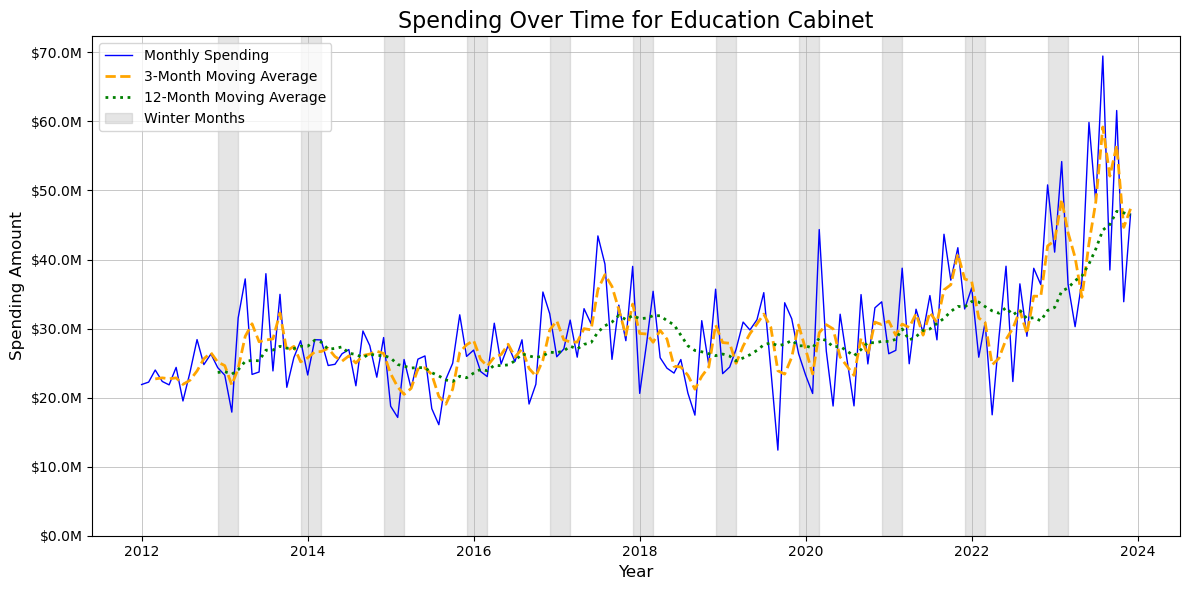

In [83]:
plot_cabinet_spending('Education Cabinet')

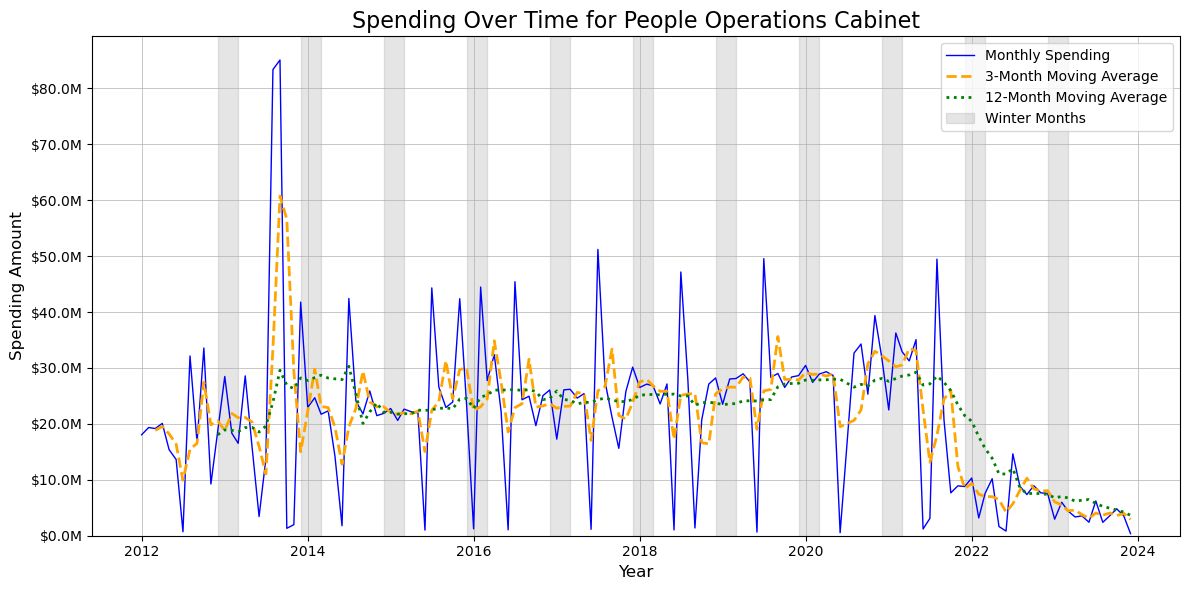

In [84]:
plot_cabinet_spending('People Operations Cabinet')

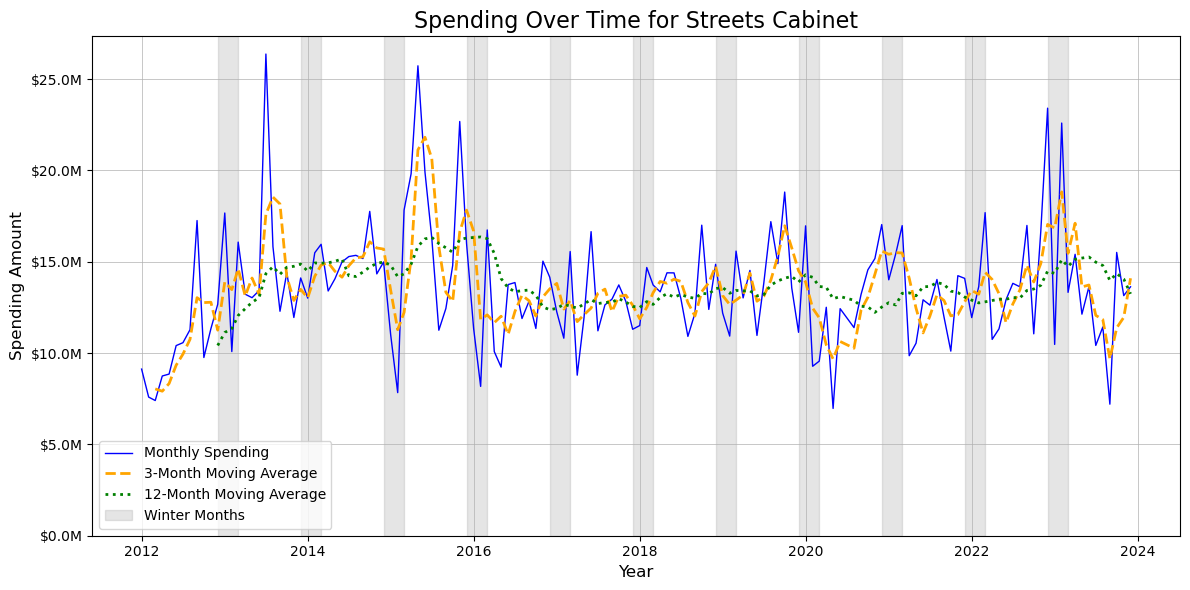

In [85]:
plot_cabinet_spending('Streets Cabinet')

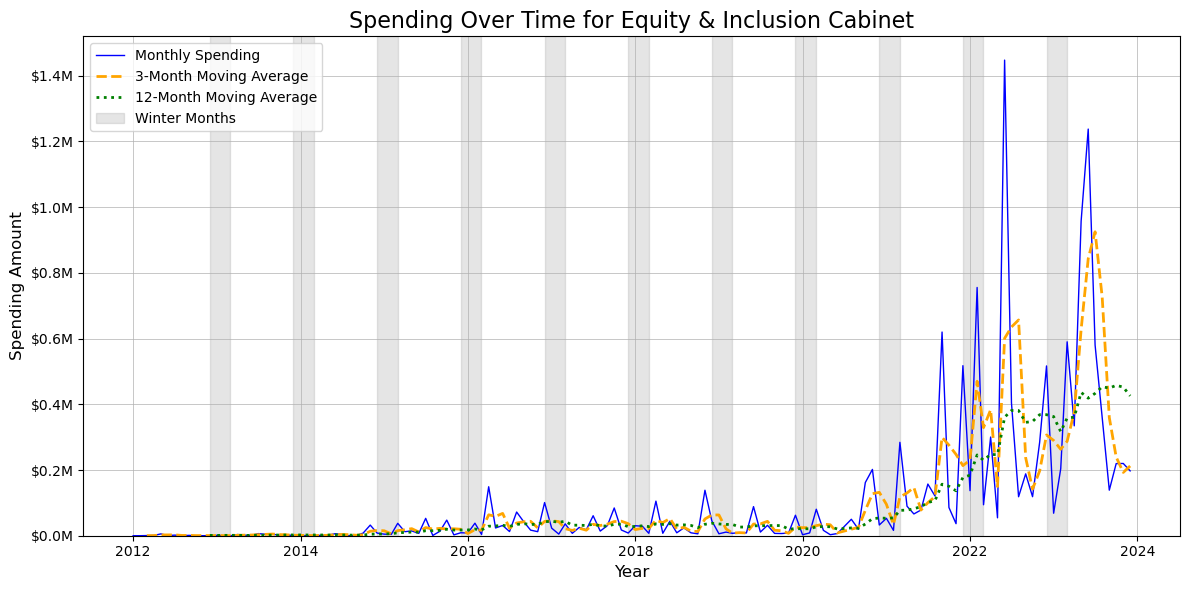

In [86]:
plot_cabinet_spending('Equity & Inclusion Cabinet')

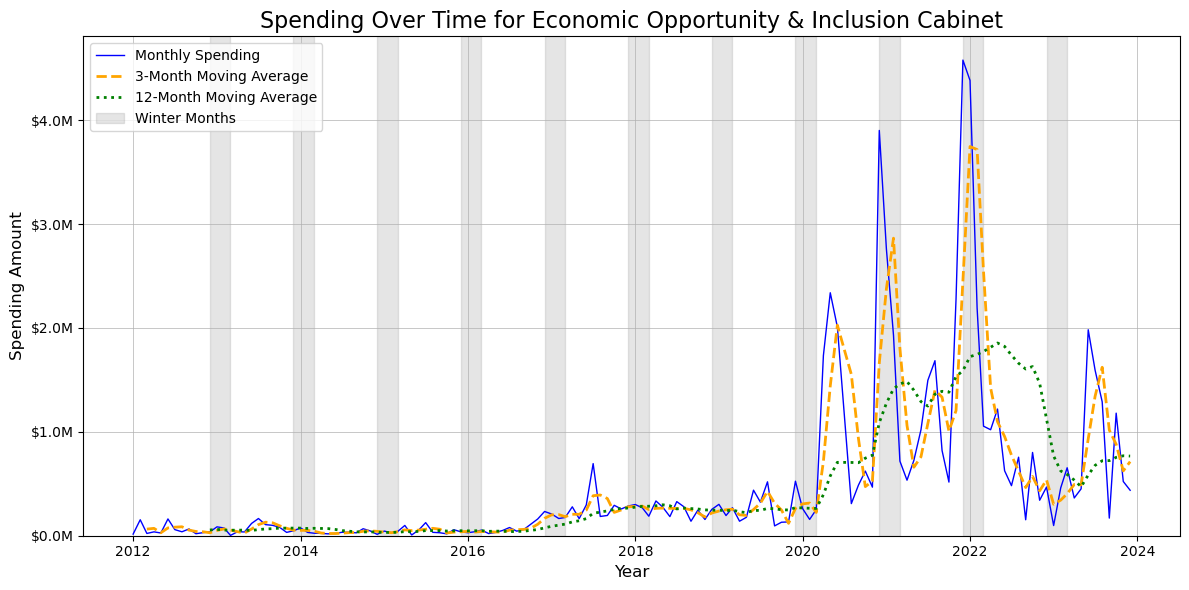

In [87]:
plot_cabinet_spending('Economic Opportunity & Inclusion Cabinet')